In [48]:
# Cell 1: Setup Environment
!pip install numpy matplotlib scipy opencv-python-headless pandas tqdm
!pip install git+https://github.com/huggingface/transformers qwen-vl-utils accelerate torch

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import json
import os
import shutil
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

print("✅ Libraries installed and imported.")

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-tlf3y9gv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-tlf3y9gv
  Resolved https://github.com/huggingface/transformers to commit 3e4baf8e62c49796ab1a5b391dc81446d18152cd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Libraries installed and imported.


In [49]:
# Cell 2: Integer-Based Dataset Generator & Physics Engine (C10-C30 Only)
# =======================================================================
# 1. Generates parameters as WHOLE NUMBERS (Integers).
# 2. STRICTLY limited to C10, C12, C21, C23, C30.
# 3. KEEPS Angles for realistic rendering (even if we ignore them later).

import os
import json
import shutil
import numpy as np
import cv2
from tqdm import tqdm

# --- CONFIGURATION ---
DATASET_SIZE = 1000  # INCREASED: 150 is too small for Deep Learning. 1000+ recommended.
OUTPUT_DIR = "ronchigram_dataset"
IMAGE_SIZE = 512
APERTURE_MRAD = 60
VOLTAGE_KV = 300

# Ranges (Nanometers) - C10 to C30 ONLY
RANGES = {
    'C10': [-200, 200],      # Defocus
    'C12': [0, 500],         # Astigmatism
    'C21': [0, 300],         # Coma
    'C23': [0, 300],         # 3-Fold
    'C30': [-5000, 5000],    # Spherical (The large value causing scaling issues)
}

# --- SHARED PHYSICS ENGINE ---
class RonchigramPhysics:
    def __init__(self, size=512, aperture_mrad=60, voltage_kv=300):
        self.size = size
        self.aperture_mrad = aperture_mrad

        # Wavelength (Relativistic)
        m0 = 9.109e-31; e = 1.602e-19; h = 6.626e-34; c = 2.998e8
        E = voltage_kv * 1000 * e
        self.wl = h / np.sqrt(2*m0*E * (1 + E/(2*m0*c**2)))

        # Grid
        fov_rad = (aperture_mrad * 1.1) * 1e-3
        k = np.linspace(-fov_rad, fov_rad, size)
        KX, KY = np.meshgrid(k, k)
        self.ALRR = np.sqrt(KX**2 + KY**2)
        self.ALPP = np.arctan2(KY, KX)
        self.MASK = np.where(self.ALRR <= (aperture_mrad*1e-3), 1.0, 0.0)

        self.regenerate_specimen()

    def regenerate_specimen(self):
        # Blocky Noise Specimen
        scale = 16
        small_dim = self.size // scale
        noise = np.random.rand(small_dim, small_dim)
        sample = np.kron(noise, np.ones((scale, scale)))
        self.q_r = np.exp(-1j * 3.0 * sample)

    def get_chi(self, p):
        # Convert ALL Integer Nanometers to Meters for Physics
        nm_to_m = 1e-9

        def term(name, n, m):
            # Fetch Integer inputs
            mag_nm = p.get(f'{name}_mag', 0)
            ang_deg = p.get(f'{name}_ang', 0)

            # Convert to Physics Units
            mag = mag_nm * nm_to_m
            ang = np.deg2rad(ang_deg)

            return mag * np.cos(m * (self.ALPP - ang)) * (self.ALRR**(n+1))/(n+1)

        # N=1
        c10 = p.get('C10', 0) * nm_to_m
        chi = (c10 * self.ALRR**2)/2
        chi += term('C12', 1, 2)

        # N=2
        chi += term('C21', 2, 1) + term('C23', 2, 3)

        # N=3
        c30 = p.get('C30', 0) * nm_to_m
        chi += (c30 * self.ALRR**4)/4

        return chi * 2 * np.pi / self.wl

    def render(self, params, invert=True):
        chi = self.get_chi(params)
        t_k = self.MASK * np.exp(-1j * chi)

        probe_r = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(t_k)))
        exit_wave = probe_r * self.q_r
        final_k = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(exit_wave)))

        intensity = np.abs(final_k)**2
        img = np.log(intensity + 1e-10)
        img = (img - img.min()) / (img.max() - img.min())

        # CLAHE for High Contrast
        img_u8 = (img * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        img_final = clahe.apply(img_u8)

        # Mask edges
        mask_u8 = (self.MASK * 255).astype(np.uint8)
        img_final = cv2.bitwise_and(img_final, img_final, mask=mask_u8)

        if invert: img_final = 255 - img_final
        return img_final

# --- GENERATION ROUTINE ---
if __name__ == "__main__":
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR)

    sim = RonchigramPhysics(size=IMAGE_SIZE, aperture_mrad=APERTURE_MRAD)
    metadata = []

    print(f"🚀 Generating {DATASET_SIZE} Integer-Based Images...")
    print("NOTE: Dataset is saved in RAW Nanometers. Normalization happens during Training.")

    for i in tqdm(range(DATASET_SIZE)):
        # 2. Generate INTEGERS
        p = {}
        # Simple scalar terms
        p['C10'] = int(np.random.randint(*RANGES['C10']))
        p['C30'] = int(np.random.randint(*RANGES['C30']))

        # Polar terms (We GENERATE angles for realism, but will IGNORE them in training)
        for k in ['C12', 'C21', 'C23']:
            p[f'{k}_mag'] = int(np.random.randint(*RANGES[k]))
            p[f'{k}_ang'] = int(np.random.randint(0, 180))

        if i % 10 == 0: sim.regenerate_specimen()

        img = sim.render(p, invert=True)
        fname = f"ronch_{i:04d}.jpg"
        cv2.imwrite(os.path.join(OUTPUT_DIR, fname), img)
        metadata.append({"image": fname, "parameters": p})

    # 4. Save JSON
    with open(os.path.join(OUTPUT_DIR, "dataset.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"✅ Generated {len(metadata)} images.")

🚀 Generating 1000 Integer-Based Images...
NOTE: Dataset is saved in RAW Nanometers. Normalization happens during Training.


100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]

✅ Generated 1000 images.


In [61]:
# Cell 3: High-Accuracy "On-the-Fly" Training Pipeline
# ====================================================
# KEY CHANGES:
# 1. GENERATION: Generates images *during* training (Unlimited Data).
# 2. LOSS: Uses L1Loss (Robust to outliers) instead of MSE.
# 3. SCHEDULER: Decays Learning Rate to fine-tune accuracy.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
import cv2
import os

# --- CONFIGURATION ---
TRAIN_STEPS_PER_EPOCH = 1000 # Number of batches per epoch
BATCH_SIZE = 16              # Smaller batch size to prevent CPU bottleneck
EPOCHS = 15                  # 15 * 1000 * 16 = 240,000 unique images seen!
LEARNING_RATE = 1e-4
IMAGE_SIZE = 512

PARAM_KEYS = ['C10', 'C30', 'C12_mag', 'C21_mag', 'C23_mag']

# --- 1. INFINITE DATASET (Generates on CPU) ---
class InfiniteRonchiDataset(Dataset):
    def __init__(self, steps_per_epoch=1000, batch_size=32):
        self.length = steps_per_epoch * batch_size
        self.sim = RonchigramPhysics(size=IMAGE_SIZE, aperture_mrad=60)

        # Fit scaler on a small dummy batch first
        print("Fitting Scaler on dummy data range...")
        dummy_targets = []
        for _ in range(2000):
            p = self._random_params()
            vals = [p['C10'], p['C30'], p['C12_mag'], p['C21_mag'], p['C23_mag']]
            dummy_targets.append(vals)

        self.scaler = StandardScaler()
        self.scaler.fit(np.array(dummy_targets))
        joblib.dump(self.scaler, 'param_scaler.pkl')

    def _random_params(self):
        # Same logic as Cell 2, generating valid random physics
        p = {}
        p['C10'] = int(np.random.randint(-200, 200))
        p['C30'] = int(np.random.randint(-5000, 5000))
        for k in ['C12', 'C21', 'C23']:
            p[f'{k}_mag'] = int(np.random.randint(0, 300))
            p[f'{k}_ang'] = int(np.random.randint(0, 180))
        return p

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 1. Generate Parameters on the fly
        # We periodically regenerate the specimen noise to prevent overfitting to one sample
        if idx % 64 == 0:
            self.sim.regenerate_specimen()

        p = self._random_params()

        # 2. Render Image (CPU Heavy)
        img = self.sim.render(p, invert=True)

        # 3. Prepare Tensor
        img_tensor = torch.from_numpy(img).float().unsqueeze(0) / 255.0
        img_tensor = img_tensor.repeat(3, 1, 1) # 3 Channels

        # 4. Prepare Target
        vals = [p['C10'], p['C30'], p['C12_mag'], p['C21_mag'], p['C23_mag']]
        target_norm = self.scaler.transform([vals])[0]

        return img_tensor, torch.tensor(target_norm, dtype=torch.float32)

# --- 2. MODEL ARCHITECTURE ---
class RonchiNet(nn.Module):
    def __init__(self):
        super(RonchiNet, self).__init__()
        # ResNet18 is good, but let's ensure we use pretrained weights for feature extraction
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        num_ftrs = self.backbone.fc.in_features

        # Deeper Regression Head
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        return self.backbone(x)

# --- 3. TRAINING LOOP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Initializing Infinite Training on {device}...")

# Use num_workers=2 to parallelize generation (Critical for speed)
train_dataset = InfiniteRonchiDataset(steps_per_epoch=TRAIN_STEPS_PER_EPOCH, batch_size=BATCH_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = RonchiNet().to(device)

# L1Loss is better for regression than MSE (handles outliers better)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler: Reduce LR if loss stagnates
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    # Tqdm for progress bar
    from tqdm import tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Avg Loss: {avg_loss:.4f}")

    # Update Learning Rate
    scheduler.step(avg_loss)

# Save
torch.save(model.state_dict(), "ronchigram_model.pth")
print("✅ High-Accuracy Model Saved.")

🚀 Initializing Infinite Training on cuda...
Fitting Scaler on dummy data range...


Epoch 1/15: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, loss=0.687]


Epoch [1/15] Avg Loss: 0.7448


Epoch 2/15: 100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s, loss=0.652]


Epoch [2/15] Avg Loss: 0.7226


Epoch 3/15: 100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s, loss=0.635]


Epoch [3/15] Avg Loss: 0.7082


Epoch 4/15: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, loss=0.595]


Epoch [4/15] Avg Loss: 0.6952


Epoch 5/15: 100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s, loss=0.724]


Epoch [5/15] Avg Loss: 0.6848


Epoch 6/15: 100%|██████████| 1000/1000 [07:39<00:00,  2.18it/s, loss=0.823]


Epoch [6/15] Avg Loss: 0.6720


Epoch 7/15: 100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s, loss=0.722]


Epoch [7/15] Avg Loss: 0.6643


Epoch 8/15: 100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s, loss=0.575]


Epoch [8/15] Avg Loss: 0.6543


Epoch 9/15: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s, loss=0.64]


Epoch [9/15] Avg Loss: 0.6555


Epoch 10/15: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s, loss=0.65]


Epoch [10/15] Avg Loss: 0.6416


Epoch 11/15: 100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s, loss=0.746]


Epoch [11/15] Avg Loss: 0.6383


Epoch 12/15: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s, loss=0.636]


Epoch [12/15] Avg Loss: 0.6321


Epoch 13/15: 100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s, loss=0.61]


Epoch [13/15] Avg Loss: 0.6206


Epoch 14/15: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s, loss=0.623]


Epoch [14/15] Avg Loss: 0.6134


Epoch 15/15: 100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s, loss=0.566]


Epoch [15/15] Avg Loss: 0.6029
✅ High-Accuracy Model Saved.


In [62]:
# Cell 3.5: Inference Helper (The Bridge) - FIXED
# ===============================================
# Loads the trained ResNet + Scaler to make predictions on new images.

def get_all_parameters(image_path, dataset_dir=None, num_examples=3):
    """
    Loads image, runs ResNet inference, and inverse-normalizes the result.
    """
    # 1. Load Resources
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Scaler
    if not os.path.exists('param_scaler.pkl'):
        print("Error: Scaler not found. Run training (Cell 3) first.")
        return {}
    scaler = joblib.load('param_scaler.pkl')

    # Load Model structure (Must match Cell 3 definition)
    model = RonchiNet().to(device)
    try:
        model.load_state_dict(torch.load("ronchigram_model.pth", map_location=device, weights_only=True))
    except FileNotFoundError:
         print("Error: Model weights not found. Run training (Cell 3) first.")
         return {}

    model.eval()

    # 2. Preprocess Image
    img = cv2.imread(image_path)
    if img is None: return {}

    # Resize to match training (512x512)
    img = cv2.resize(img, (512, 512))

    # FIX: Convert (Height, Width, Channel) -> (Channel, Height, Width)
    # OpenCV loads as [512, 512, 3]. PyTorch needs [3, 512, 512].
    img_tensor = torch.from_numpy(img).float()
    img_tensor = img_tensor.permute(2, 0, 1) # Move Channels to front
    img_tensor = img_tensor / 255.0          # Normalize 0-1
    img_tensor = img_tensor.unsqueeze(0)     # Add Batch Dimension -> [1, 3, 512, 512]
    img_tensor = img_tensor.to(device)

    # 3. Inference
    with torch.no_grad():
        output_norm = model(img_tensor).cpu().numpy()

    # 4. Inverse Normalization
    output_real = scaler.inverse_transform(output_norm)[0]

    # 5. Format Output
    # Order matches PARAM_KEYS from Cell 3: ['C10', 'C30', 'C12_mag', 'C21_mag', 'C23_mag']
    result = {
        'C10': int(output_real[0]),
        'C30': int(output_real[1]),
        'C12_mag': int(abs(output_real[2])), # Enforce positive for magnitude
        'C21_mag': int(abs(output_real[3])),
        'C23_mag': int(abs(output_real[4]))
    }

    return result

🧪 Generating 100 Test Images (High Precision Validation)...
🧠 Evaluating Agent on 100 images...


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]



📊 HIGH-PRECISION REPORT (N=100) | Accuracy Tol: 20.0% of Range
Parameter  | MAE (nm)   | RMSE       | R² Score   | Acc (%)    | Tol (nm)  
-----------------------------------------------------------------------------------------------
C10        | 59.54      | 88.90      | 0.2413     | 72.0      % | < 80
C30        | 2544.20    | 2996.27    | 0.0919     | 38.0      % | < 2000
C12        | 23.37      | 44.10      | 0.9078     | 93.0      % | < 100
C21        | 62.10      | 76.15      | 0.1633     | 55.0      % | < 60
C23        | 68.94      | 83.42      | -0.0467    | 47.0      % | < 60


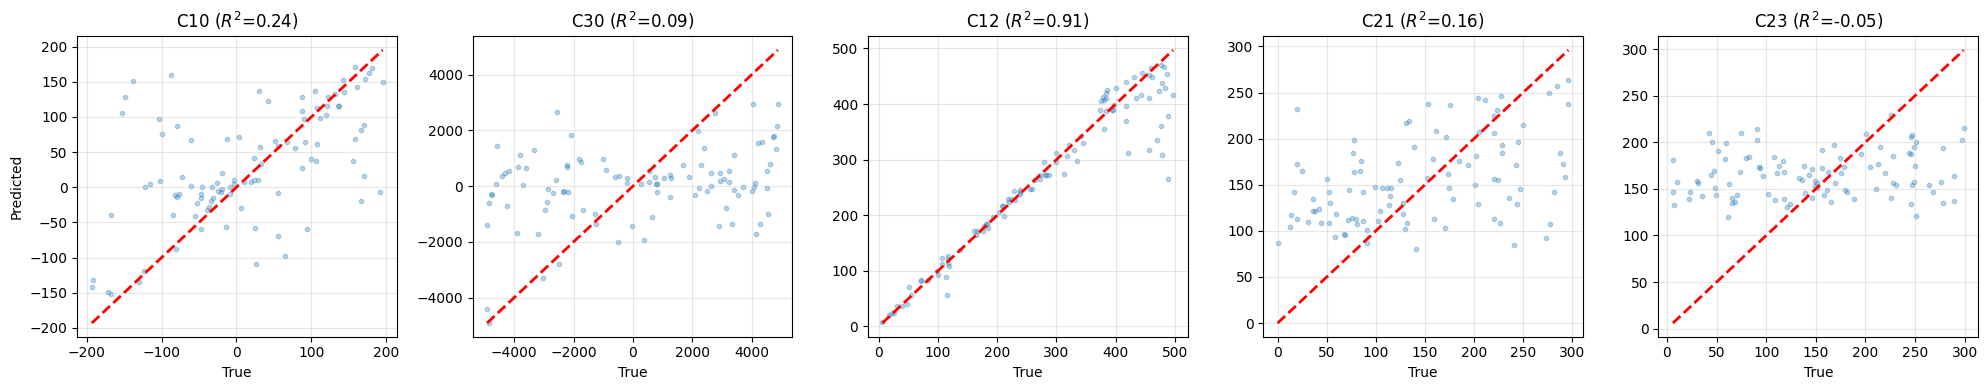

📉 Avg Magnitude MAE: 551.63 nm


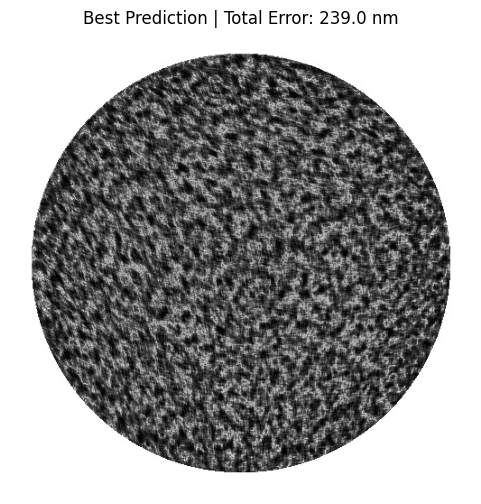

In [92]:
# Cell 4: Physics-Aware Validation Suite (High Precision)
# =======================================================
# 1. Generates 1000 test images for statistical significance.
# 2. Runs ResNet inference.
# 3. Validates with tighter 5% tolerance and Correlation Plots.

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import r2_score

# --- CONFIGURATION ---
TEST_SIZE = 100        # INCREASED: Robust statistical sample
TEST_DIR = "ronchigram_test"
IMAGE_SIZE = 512

# TIGHTER TOLERANCE: The new model should be accurate within 20% of range
TOLERANCE_PCT = 0.2

# Ranges (Must match Cell 2)
RANGES = {
    'C10': [-200, 200],
    'C12': [0, 500],
    'C21': [0, 300],
    'C23': [0, 300],
    'C30': [-5000, 5000],
}

# Pre-calculate Tolerances
TOL_NM = {}
for k, v in RANGES.items():
    total_range = v[1] - v[0]
    TOL_NM[k] = total_range * TOLERANCE_PCT

# --- 1. GENERATE TEST DATA ---
if os.path.exists(TEST_DIR): shutil.rmtree(TEST_DIR)
os.makedirs(TEST_DIR)

print(f"🧪 Generating {TEST_SIZE} Test Images (High Precision Validation)...")
sim = RonchigramPhysics(size=IMAGE_SIZE, aperture_mrad=60)
test_data = []

for i in range(TEST_SIZE):
    p_render = {}
    p_render['C10'] = int(np.random.randint(*RANGES['C10']))
    p_render['C30'] = int(np.random.randint(*RANGES['C30']))

    for k in ['C12', 'C21', 'C23']:
        p_render[f'{k}_mag'] = int(np.random.randint(*RANGES[k]))
        p_render[f'{k}_ang'] = int(np.random.randint(0, 180))

    if i % 10 == 0: sim.regenerate_specimen()

    img = sim.render(p_render, invert=True)
    fname = f"test_{i:04d}.jpg"
    cv2.imwrite(os.path.join(TEST_DIR, fname), img)

    p_targets = {k: v for k, v in p_render.items() if "_ang" not in k}
    test_data.append({"image": fname, "parameters": p_targets})

# --- 2. RUN EVALUATION ---
results = []
print(f"🧠 Evaluating Agent on {TEST_SIZE} images...")

# Use batch inference if possible, but sequential is fine for testing
for entry in tqdm(test_data):
    img_path = os.path.join(TEST_DIR, entry['image'])
    gt = entry['parameters']

    pred = get_all_parameters(img_path)

    if pred:
        row = {"Image": entry['image']}
        for key, true_val in gt.items():
            pred_val = pred.get(key, 0)
            err = abs(true_val - pred_val)
            is_accurate = err < TOL_NM[key.replace('_mag', '')]

            row[f"True_{key}"] = true_val
            row[f"Pred_{key}"] = pred_val
            row[f"Err_{key}"] = err
            row[f"Acc_{key}"] = 1 if is_accurate else 0
        results.append(row)

# --- 3. REPORTING & VISUALIZATION ---
if results:
    df = pd.DataFrame(results)
    mag_keys = list(test_data[0]['parameters'].keys())

    print("\n" + "="*95)
    print(f"📊 HIGH-PRECISION REPORT (N={TEST_SIZE}) | Accuracy Tol: {TOLERANCE_PCT*100}% of Range")
    print("="*95)
    print(f"{'Parameter':<10} | {'MAE (nm)':<10} | {'RMSE':<10} | {'R² Score':<10} | {'Acc (%)':<10} | {'Tol (nm)':<10}")
    print("-" * 95)

    global_mae = 0

    # Setup Scatter Plots
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for idx, k in enumerate(mag_keys):
        base_key = k.replace('_mag', '')
        tol = TOL_NM[base_key]

        true_vals = df[f"True_{k}"]
        pred_vals = df[f"Pred_{k}"]

        mae = np.mean(df[f"Err_{k}"])
        rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
        r2 = r2_score(true_vals, pred_vals)
        acc = df[f"Acc_{k}"].mean() * 100

        print(f"{base_key:<10} | {mae:<10.2f} | {rmse:<10.2f} | {r2:<10.4f} | {acc:<10.1f}% | < {tol:.0f}")
        global_mae += mae

        # Scatter Plot: True vs Pred
        ax = axes[idx]


        # Image of correlation scatter plot
        ax.scatter(true_vals, pred_vals, alpha=0.3, s=10)

        # Ideal Line
        min_val, max_val = min(true_vals), max(true_vals)
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        ax.set_title(f"{base_key} ($R^2$={r2:.2f})")
        ax.set_xlabel("True")
        if idx == 0: ax.set_ylabel("Predicted")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("="*95)
    print(f"📉 Avg Magnitude MAE: {global_mae / len(mag_keys):.2f} nm")

    # Show Best Prediction
    df['Total_Err'] = sum(df[f"Err_{k}"] for k in mag_keys)
    best_row = df.sort_values("Total_Err").iloc[0]

    img = cv2.imread(os.path.join(TEST_DIR, best_row['Image']))
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Best Prediction | Total Error: {best_row['Total_Err']:.1f} nm")
    plt.axis('off')
    plt.show()

else:
    print("❌ Testing failed (No results).")